# PursuitEvasion16x16-v0 Heuristic experiment analysis 

In [1]:
import copy
import os.path as osp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import posggym_agents

import baposgmcp.plot as plot_utils
import baposgmcp.plot.paper as paper_utils
from baposgmcp.config import BASE_REPO_DIR

algname = paper_utils.algname
baselinealgname = paper_utils.baselinealgname

BASE_EXP_DIR = osp.join(
    BASE_REPO_DIR, 
    "experiments", 
    "PursuitEvasion16x16-v0"
)
BASE_RESULTS_DIR = osp.join(BASE_EXP_DIR, "results")

figure_dir = osp.join(BASE_EXP_DIR, "figures")
baposgmcp_results_file = osp.join(BASE_RESULTS_DIR, "experiment_results.csv")
baposgmcp_time_results_file = osp.join(BASE_RESULTS_DIR, "time_experiment_results.csv")
baposgmcp_pi_results_file = osp.join(BASE_RESULTS_DIR, "pi_experiment_results.csv")
policy_results_file = osp.join(
    posggym_agents.config.BASE_DIR, 'agents', "pursuitevasion16x16_v0", "results", "pairwise_results.csv"
)

## Define Co-Player Prior

In [2]:
# Uniform
# Note K4 is not in prior 
policy_prior = {
    0: {
        "klr_k0_seed0_i0-v0": 1/4,
        "klr_k1_seed0_i0-v0": 1/4,
        "klr_k2_seed0_i0-v0": 1/4,
        "klr_k3_seed0_i0-v0": 1/4
    },
    1: {
        "klr_k0_seed0_i1-v0": 1/4,
        "klr_k1_seed0_i1-v0": 1/4,
        "klr_k2_seed0_i1-v0": 1/4,
        "klr_k3_seed0_i1-v0": 1/4
    }
}
coplayer_policy_ids = list(policy_prior[0]) + list(policy_prior[1])
coplayer_policy_ids.sort()
fixed_policy_ids = coplayer_policy_ids + ["klr_k4_seed0_i0-v0", "klr_k4_seed0_i1-v0"]
fixed_policy_ids.sort()

# Problem size

- Grid size = 16 x 16
- Num free coods = 145 
- Num goal = 3

**States**

```
= evader_states * pursuer_states 
= (pos * dir * goal * min_goal_dist) * (pos * dir)
= (145 * 4 * 3 * 23) * (145 * 4) 
= 23,211,600
```

**Actions** = 4 (Forward, Backward, Left, Right)

**Observations**

```
= adj_cells * seed * heard * evader_start_coord, pursuer_start_coord * goal_coord
= 2**4 * 2 * 2 * 6 * 2 * 6
= 4,608
```

Coord observations are constant throught an episode so only influence branching for the initial observation.
Given agents know their initial location and the map is fixed and known the branching is `2*2=4`.

## The Environment

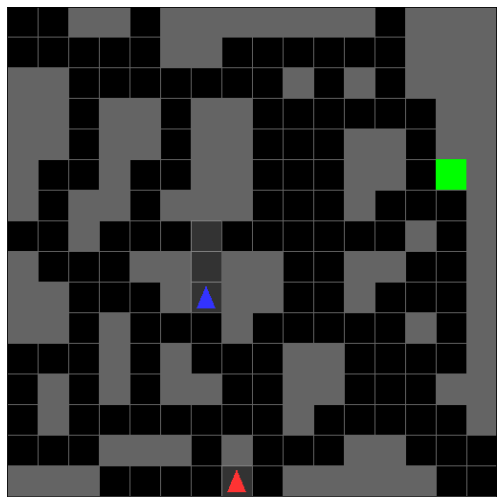

In [3]:
fig, ax = plot_utils.plot_environment("PursuitEvasion16x16-v0", (9, 9))
fig.savefig(osp.join(figure_dir, "env.png"))
plt.show()

## Loading Fixed Policy Data

In [4]:
policy_df = plot_utils.import_results(
    policy_results_file, clean_policy_id=True, add_coplayer_policy_id=True
)

all_fixed_policy_ids = policy_df["policy_id"].unique().tolist()
all_fixed_policy_ids.sort()
print("All Fixed Policies")
print("------------------")
for pi_id in all_fixed_policy_ids:
    print("  ", pi_id)
    
    
# Drop unneeded co-player policies
policy_df = policy_df[policy_df["policy_id"].isin(fixed_policy_ids)]
fixed_policy_ids = policy_df["policy_id"].unique().tolist()
fixed_policy_ids.sort()
print("\nExperiment Fixed Policies")
print("-------------------------")
for pi_id in fixed_policy_ids:
    print("  ", pi_id)

print("\nColumns")
print("-------")
for c in policy_df.columns:
    print("  ", c)

All Fixed Policies
------------------
   klr_k0_seed0_i0-v0
   klr_k0_seed0_i1-v0
   klr_k0_seed1_i0-v0
   klr_k0_seed1_i1-v0
   klr_k0_seed2_i0-v0
   klr_k0_seed2_i1-v0
   klr_k0_seed3_i0-v0
   klr_k0_seed3_i1-v0
   klr_k0_seed4_i0-v0
   klr_k0_seed4_i1-v0
   klr_k1_seed0_i0-v0
   klr_k1_seed0_i1-v0
   klr_k1_seed1_i0-v0
   klr_k1_seed1_i1-v0
   klr_k1_seed2_i0-v0
   klr_k1_seed2_i1-v0
   klr_k1_seed3_i0-v0
   klr_k1_seed3_i1-v0
   klr_k1_seed4_i0-v0
   klr_k1_seed4_i1-v0
   klr_k2_seed0_i0-v0
   klr_k2_seed0_i1-v0
   klr_k2_seed1_i0-v0
   klr_k2_seed1_i1-v0
   klr_k2_seed2_i0-v0
   klr_k2_seed2_i1-v0
   klr_k2_seed3_i0-v0
   klr_k2_seed3_i1-v0
   klr_k2_seed4_i0-v0
   klr_k2_seed4_i1-v0
   klr_k3_seed0_i0-v0
   klr_k3_seed0_i1-v0
   klr_k3_seed1_i0-v0
   klr_k3_seed1_i1-v0
   klr_k3_seed2_i0-v0
   klr_k3_seed2_i1-v0
   klr_k3_seed3_i0-v0
   klr_k3_seed3_i1-v0
   klr_k3_seed4_i0-v0
   klr_k3_seed4_i1-v0
   klr_k4_seed0_i0-v0
   klr_k4_seed0_i1-v0
   klr_k4_seed1_i0-v0
   klr_k4_seed1_

## Fixed policies pairwise performance

This is what was used to generate the meta-policies.

In [5]:
fixed_policies_0 = [
    "klr_k0_seed0_i0-v0",
    "klr_k1_seed0_i0-v0",
    "klr_k2_seed0_i0-v0",
    "klr_k3_seed0_i0-v0",
    "klr_k4_seed0_i0-v0"
]
fixed_policies_1 = [
    "klr_k0_seed0_i1-v0",
    "klr_k1_seed0_i1-v0",
    "klr_k2_seed0_i1-v0",
    "klr_k3_seed0_i1-v0",
    "klr_k4_seed0_i1-v0"
]
fixed_policy_labels={
    "klr_k0_seed0_i0-v0": "K0_0",
    "klr_k1_seed0_i0-v0": "K1_0",
    "klr_k2_seed0_i0-v0": "K2_0",
    "klr_k3_seed0_i0-v0": "K3_0",
    "klr_k4_seed0_i0-v0": "K4_0",
    "klr_k0_seed0_i1-v0": "K0_1",
    "klr_k1_seed0_i1-v0": "K1_1",
    "klr_k2_seed0_i1-v0": "K2_1",
    "klr_k3_seed0_i1-v0": "K3_1",
    "klr_k4_seed0_i1-v0": "K4_1",
}

/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]
/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]
/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_i

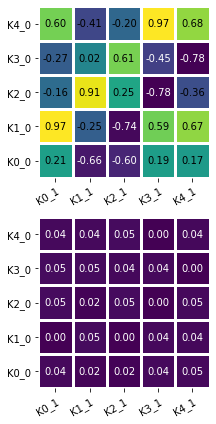

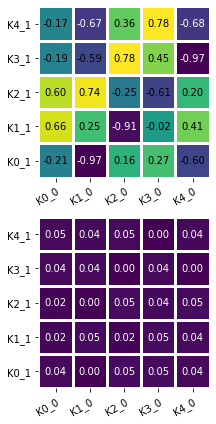

In [6]:
fig, axs = plot_utils.plot_pairwise_comparison(
    policy_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    y_err_key="episode_return_CI",
    vrange=None, 
    figsize=(3, 6), 
    valfmt="{x:.2f}",
    policies=fixed_policies_0,
    coplayer_policies=fixed_policies_1,
    policy_labels=fixed_policy_labels,
    average_duplicates=True,
    duplicate_warning=False
)
fig.savefig(osp.join(figure_dir, "fixed_policy_payoff_0.png"))

fig, axs = plot_utils.plot_pairwise_comparison(
    policy_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    y_err_key="episode_return_CI",
    vrange=None, 
    figsize=(3, 6), 
    valfmt="{x:.2f}",
    policies=fixed_policies_1,
    coplayer_policies=fixed_policies_0,
    policy_labels=fixed_policy_labels,
    average_duplicates=True,
    duplicate_warning=False
)
fig.savefig(osp.join(figure_dir, "fixed_policy_payoff_1.png"))

In [7]:
# Get payofss in meta policy dictionary format (for use in experiments)
pw_values, (row_policies, col_policies) = plot_utils.get_pairwise_values(
    policy_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    policies=fixed_policies_0,
    coplayer_policies=fixed_policies_1,
    average_duplicates=True,
    duplicate_warning=True
)

for c, col_policy in enumerate(col_policies):
    print(f'(-1, "{col_policy}"):', "{")
    for r, row_policy in enumerate(row_policies):
        print(f'    "{row_policy}": {pw_values[r][c]:.2f},')
    print("},")
    
pw_values, (row_policies, col_policies) = plot_utils.get_pairwise_values(
    policy_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    policies=fixed_policies_1,
    coplayer_policies=fixed_policies_0,
    average_duplicates=True,
    duplicate_warning=True
)


for c, col_policy in enumerate(col_policies):
    print(f'("{col_policy}", -1):', "{")
    for r, row_policy in enumerate(row_policies):
        print(f'    "{row_policy}": {pw_values[r][c]:.2f},')
    print("},")

/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]


(-1, "klr_k0_seed0_i1-v0"): {
    "klr_k0_seed0_i0-v0": 0.21,
    "klr_k1_seed0_i0-v0": 0.97,
    "klr_k2_seed0_i0-v0": -0.16,
    "klr_k3_seed0_i0-v0": -0.27,
    "klr_k4_seed0_i0-v0": 0.60,
},
(-1, "klr_k1_seed0_i1-v0"): {
    "klr_k0_seed0_i0-v0": -0.66,
    "klr_k1_seed0_i0-v0": -0.25,
    "klr_k2_seed0_i0-v0": 0.91,
    "klr_k3_seed0_i0-v0": 0.02,
    "klr_k4_seed0_i0-v0": -0.41,
},
(-1, "klr_k2_seed0_i1-v0"): {
    "klr_k0_seed0_i0-v0": -0.60,
    "klr_k1_seed0_i0-v0": -0.74,
    "klr_k2_seed0_i0-v0": 0.25,
    "klr_k3_seed0_i0-v0": 0.61,
    "klr_k4_seed0_i0-v0": -0.20,
},
(-1, "klr_k3_seed0_i1-v0"): {
    "klr_k0_seed0_i0-v0": 0.19,
    "klr_k1_seed0_i0-v0": 0.59,
    "klr_k2_seed0_i0-v0": -0.78,
    "klr_k3_seed0_i0-v0": -0.45,
    "klr_k4_seed0_i0-v0": 0.97,
},
(-1, "klr_k4_seed0_i1-v0"): {
    "klr_k0_seed0_i0-v0": 0.17,
    "klr_k1_seed0_i0-v0": 0.67,
    "klr_k2_seed0_i0-v0": -0.36,
    "klr_k3_seed0_i0-v0": -0.78,
    "klr_k4_seed0_i0-v0": 0.68,
},


/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]


("klr_k0_seed0_i0-v0", -1): {
    "klr_k0_seed0_i1-v0": -0.21,
    "klr_k1_seed0_i1-v0": 0.66,
    "klr_k2_seed0_i1-v0": 0.60,
    "klr_k3_seed0_i1-v0": -0.19,
    "klr_k4_seed0_i1-v0": -0.17,
},
("klr_k1_seed0_i0-v0", -1): {
    "klr_k0_seed0_i1-v0": -0.97,
    "klr_k1_seed0_i1-v0": 0.25,
    "klr_k2_seed0_i1-v0": 0.74,
    "klr_k3_seed0_i1-v0": -0.59,
    "klr_k4_seed0_i1-v0": -0.67,
},
("klr_k2_seed0_i0-v0", -1): {
    "klr_k0_seed0_i1-v0": 0.16,
    "klr_k1_seed0_i1-v0": -0.91,
    "klr_k2_seed0_i1-v0": -0.25,
    "klr_k3_seed0_i1-v0": 0.78,
    "klr_k4_seed0_i1-v0": 0.36,
},
("klr_k3_seed0_i0-v0", -1): {
    "klr_k0_seed0_i1-v0": 0.27,
    "klr_k1_seed0_i1-v0": -0.02,
    "klr_k2_seed0_i1-v0": -0.61,
    "klr_k3_seed0_i1-v0": 0.45,
    "klr_k4_seed0_i1-v0": 0.78,
},
("klr_k4_seed0_i0-v0", -1): {
    "klr_k0_seed0_i1-v0": -0.60,
    "klr_k1_seed0_i1-v0": 0.41,
    "klr_k2_seed0_i1-v0": 0.20,
    "klr_k3_seed0_i1-v0": -0.97,
    "klr_k4_seed0_i1-v0": -0.68,
},


### Add Full-Knowledge Best-Response baseline

In [8]:
# Maps policy_id -> best response policy_id
best_response_map = {
    0: {
        "klr_k0_seed0_i1-v0": "klr_k1_seed0_i0-v0",
        "klr_k1_seed0_i1-v0": "klr_k2_seed0_i0-v0",
        "klr_k2_seed0_i1-v0": "klr_k3_seed0_i0-v0",
        "klr_k3_seed0_i1-v0": "klr_k4_seed0_i0-v0",
        # "klr_k4_seed0_i1-v0": "klr_k4_seed0_i0-v0",
    }, 
    1: {
        "klr_k0_seed0_i0-v0": "klr_k1_seed0_i1-v0",
        "klr_k1_seed0_i0-v0": "klr_k2_seed0_i1-v0",
        "klr_k2_seed0_i0-v0": "klr_k3_seed0_i1-v0",
        "klr_k3_seed0_i0-v0": "klr_k4_seed0_i1-v0",
        # "klr_k4_seed0_i0-v0": "klr_k4_seed0_i1-v0",
    }
}

new_rows = []
for (agent_id, coplayer_agent_id) in [(0, 1), (1, 0)]:
    for coplayer_policy_id, br_policy_id in best_response_map[agent_id].items():
        next_exp_id = policy_df["exp_id"].max() + 1
        br_row = policy_df.loc[
            (policy_df["agent_id"] == agent_id)
            & (policy_df["policy_id"] == br_policy_id) 
            & (policy_df["coplayer_policy_id"] == coplayer_policy_id)
        ].copy()
        br_coplayer_row = policy_df.loc[
            (policy_df["agent_id"] == coplayer_agent_id)
            & (policy_df["exp_id"].isin(br_row["exp_id"]))
        ].copy()
        # update policy id to baseline name
        br_row["policy_id"] = f"full-knowledge-br_i{agent_id}"
        # update exp ids to avoid duplicates
        br_row["exp_id"] = next_exp_id
        br_coplayer_row["exp_id"] = next_exp_id
        new_rows.append(br_row)
        new_rows.append(br_coplayer_row)

print(len(new_rows))
br_df = pd.concat(new_rows, axis='rows').reset_index(drop=True)
print(len(br_df))
policy_br_df = pd.concat([policy_df, br_df], ignore_index=True)

print(len(policy_br_df))
policy_br_df[policy_br_df["policy_id"].isin(["full-knowledge-br_i0", "full-knowledge-br_i1"])]

16
16
386


,exp_id,agent_id,env_id,policy_id,exp_seed,num_episodes,time_limit,episode_return_mean,episode_return_std,episode_return_max,...,episode_steps_CI,episode_time_CI,prop_LOSS,prop_DRAW,prop_WIN,prop_NA,num_sims,search_time_limit,truncated,coplayer_policy_id
370,1339,0,PursuitEvasion16x16-v0,full-knowledge-br_i0,0,1000,None,0.965419,0.018966,0.991935,...,0.272501,0.001036,0.000,0.0,1.000,0.000,0,NaN,False,klr_k0_seed0_i1-v0
372,1339,0,PursuitEvasion16x16-v0,full-knowledge-br_i0,0,1000,None,0.911089,0.296733,0.991935,...,0.374425,0.001199,0.032,0.0,0.968,0.000,0,NaN,False,klr_k1_seed0_i1-v0
374,1339,0,PursuitEvasion16x16-v0,full-knowledge-br_i0,0,1000,None,0.608452,0.607099,0.991935,...,1.728013,0.005550,0.122,0.0,0.714,0.164,0,NaN,False,klr_k2_seed0_i1-v0
376,1339,0,PursuitEvasion16x16-v0,full-knowledge-br_i0,0,1000,None,0.965653,0.019036,0.991935,...,0.274766,0.001033,0.000,0.0,1.000,0.000,0,NaN,False,klr_k3_seed0_i1-v0
378,1339,1,PursuitEvasion16x16-v0,full-knowledge-br_i1,0,1000,None,0.663605,0.382248,0.798387,...,0.257832,0.000837,0.053,0.0,0.947,0.000,0,NaN,False,klr_k0_seed0_i0-v0
380,1339,1,PursuitEvasion16x16-v0,full-knowledge-br_i1,0,1000,None,0.740653,0.028971,0.790323,...,0.205305,0.000668,0.000,0.0,1.000,0.000,0,NaN,False,klr_k1_seed0_i0-v0
382,1339,1,PursuitEvasion16x16-v0,full-knowledge-br_i1,0,1000,None,0.779145,0.017689,0.806452,...,0.180085,0.000591,0.000,0.0,1.000,0.000,0,NaN,False,klr_k2_seed0_i0-v0
384,1339,1,PursuitEvasion16x16-v0,full-knowledge-br_i1,0,1000,None,0.777556,0.012517,0.806452,...,0.253001,0.000852,0.000,0.0,1.000,0.000,0,NaN,False,klr_k3_seed0_i0-v0


## Loading BAPOSGMCP Data

In [9]:
baposgmcp_df = plot_utils.import_results(
    baposgmcp_results_file, clean_policy_id=True, add_coplayer_policy_id=True
)
policy_ids = baposgmcp_df["policy_id"].unique().tolist()
policy_ids.sort()
print("Policies")
print("--------")
for pi_id in policy_ids:
    print("  ", pi_id)

print("\nColumns")
print("-------")
for c in baposgmcp_df.columns:
    print("  ", c)

/home/jonathon/code/ba-posgmcp/baposgmcp/plot/utils.py:186: DtypeWarning: Columns (8,9,10,11,14,15,18,19,20,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(result_file)


Policies
--------
   baposgmcp-fixed_i0_piklrk0seed0i0-v0_numsims1000_truncatedTrue
   baposgmcp-fixed_i0_piklrk0seed0i0-v0_numsims100_truncatedTrue
   baposgmcp-fixed_i0_piklrk0seed0i0-v0_numsims10_truncatedTrue
   baposgmcp-fixed_i0_piklrk0seed0i0-v0_numsims500_truncatedTrue
   baposgmcp-fixed_i0_piklrk0seed0i0-v0_numsims50_truncatedTrue
   baposgmcp-fixed_i0_piklrk1seed0i0-v0_numsims1000_truncatedTrue
   baposgmcp-fixed_i0_piklrk1seed0i0-v0_numsims100_truncatedTrue
   baposgmcp-fixed_i0_piklrk1seed0i0-v0_numsims10_truncatedTrue
   baposgmcp-fixed_i0_piklrk1seed0i0-v0_numsims500_truncatedTrue
   baposgmcp-fixed_i0_piklrk1seed0i0-v0_numsims50_truncatedTrue
   baposgmcp-fixed_i0_piklrk2seed0i0-v0_numsims1000_truncatedTrue
   baposgmcp-fixed_i0_piklrk2seed0i0-v0_numsims100_truncatedTrue
   baposgmcp-fixed_i0_piklrk2seed0i0-v0_numsims10_truncatedTrue
   baposgmcp-fixed_i0_piklrk2seed0i0-v0_numsims500_truncatedTrue
   baposgmcp-fixed_i0_piklrk2seed0i0-v0_numsims50_truncatedTrue
   baposgm

In [10]:
baposgmcp_time_df = plot_utils.import_results(
    baposgmcp_time_results_file, clean_policy_id=True, add_coplayer_policy_id=True
)
time_policy_ids = baposgmcp_time_df["policy_id"].unique().tolist()
time_policy_ids.sort()
print("Policies")
print("--------")
for pi_id in time_policy_ids:
    print("  ", pi_id)

print("\nColumns")
print("-------")
for c in baposgmcp_time_df.columns:
    print("  ", c)

Policies
--------
   baposgmcp-random_i0_searchtimelimit0.1_truncatedFalse
   baposgmcp-random_i0_searchtimelimit10_truncatedFalse
   baposgmcp-random_i0_searchtimelimit1_truncatedFalse
   baposgmcp-random_i0_searchtimelimit20_truncatedFalse
   baposgmcp-random_i0_searchtimelimit5_truncatedFalse
   baposgmcp-random_i1_searchtimelimit0.1_truncatedFalse
   baposgmcp-random_i1_searchtimelimit10_truncatedFalse
   baposgmcp-random_i1_searchtimelimit1_truncatedFalse
   baposgmcp-random_i1_searchtimelimit20_truncatedFalse
   baposgmcp-random_i1_searchtimelimit5_truncatedFalse
   baposgmcp_metasoftmax_i0_searchtimelimit0.1_truncatedTrue
   baposgmcp_metasoftmax_i0_searchtimelimit10_truncatedTrue
   baposgmcp_metasoftmax_i0_searchtimelimit1_truncatedTrue
   baposgmcp_metasoftmax_i0_searchtimelimit20_truncatedTrue
   baposgmcp_metasoftmax_i0_searchtimelimit5_truncatedTrue
   baposgmcp_metasoftmax_i1_searchtimelimit0.1_truncatedTrue
   baposgmcp_metasoftmax_i1_searchtimelimit10_truncatedTrue
   b

In [11]:
baposgmcp_pi_df = plot_utils.import_results(
    baposgmcp_pi_results_file, clean_policy_id=True, add_coplayer_policy_id=True
)
pi_policy_ids = baposgmcp_pi_df["policy_id"].unique().tolist()
pi_policy_ids.sort()
print("Policies")
print("--------")
for pi_id in pi_policy_ids:
    print("  ", pi_id)

print("\nColumns")
print("-------")
for c in baposgmcp_pi_df.columns:
    print("  ", c)

/home/jonathon/code/ba-posgmcp/baposgmcp/plot/utils.py:186: DtypeWarning: Columns (8,9,10,12,13,16,17,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(result_file)


Policies
--------
   baposgmcp-fixed_i0_piklrk0seed0i0-v0_searchtimelimit0.1_truncatedTrue
   baposgmcp-fixed_i0_piklrk0seed0i0-v0_searchtimelimit10_truncatedTrue
   baposgmcp-fixed_i0_piklrk0seed0i0-v0_searchtimelimit1_truncatedTrue
   baposgmcp-fixed_i0_piklrk0seed0i0-v0_searchtimelimit20_truncatedTrue
   baposgmcp-fixed_i0_piklrk0seed0i0-v0_searchtimelimit5_truncatedTrue
   baposgmcp-fixed_i0_piklrk1seed0i0-v0_searchtimelimit0.1_truncatedTrue
   baposgmcp-fixed_i0_piklrk1seed0i0-v0_searchtimelimit10_truncatedTrue
   baposgmcp-fixed_i0_piklrk1seed0i0-v0_searchtimelimit1_truncatedTrue
   baposgmcp-fixed_i0_piklrk1seed0i0-v0_searchtimelimit20_truncatedTrue
   baposgmcp-fixed_i0_piklrk1seed0i0-v0_searchtimelimit5_truncatedTrue
   baposgmcp-fixed_i0_piklrk2seed0i0-v0_searchtimelimit0.1_truncatedTrue
   baposgmcp-fixed_i0_piklrk2seed0i0-v0_searchtimelimit10_truncatedTrue
   baposgmcp-fixed_i0_piklrk2seed0i0-v0_searchtimelimit1_truncatedTrue
   baposgmcp-fixed_i0_piklrk2seed0i0-v0_searchti

## Combine data

In [12]:
def combine_dfs(df1, df2):
    # First need to update exp_ids of one dataframe so there are no duplicate exp_ids 
    df1_max_exp_id = df1["exp_id"].max()
    if df2["exp_id"].min() <= df1_max_exp_id:
        df2["exp_id"] += df1_max_exp_id+1

    combined_df = pd.concat([df1, df2]).reset_index(drop = True)

    def add_alg_id(row):
        pi_id = row["policy_id"]
        if pi_id.startswith("klr"):
            return "fixed"
        tokens = pi_id.split("_")
        alg_id = "_".join([
            t for t in tokens 
            if all(
                s not in t for s in [
                    "actionselection", "numsims", "truncated", "greedy", "softmax", 
                    "uniform", "piklr", "i0", "i1", "searchtimelimit"
                ]
            )
        ])
        return alg_id


    def add_meta_pi(row):
        pi_id = row["policy_id"]
        for meta_pi in ["greedy", "softmax", "uniform"]:
            if meta_pi in pi_id:
                return meta_pi
        return "NA"


    combined_df["alg_id"] = combined_df.apply(add_alg_id, axis=1)
    combined_df["meta_pi"] = combined_df.apply(add_meta_pi, axis=1)

    policy_ids = combined_df["policy_id"].unique().tolist()
    policy_ids.sort()
    print("Policies")
    print("--------")
    for pi_id in policy_ids:
        print("  ", pi_id)

    alg_ids = combined_df["alg_id"].unique().tolist()
    alg_ids.sort()
    print("\nAlg IDs")
    print("-------")
    for n in alg_ids:
        print("  ", n)

    print("\nMeta Pis:")
    print("---------")
    print(combined_df["meta_pi"].unique().tolist())

    print("\nColumns")
    print("-------")
    for c in combined_df.columns:
        print("  ", c)
        
    return combined_df

In [13]:
baposgmcp_combined_df = combine_dfs(baposgmcp_df, policy_br_df)

Policies
--------
   baposgmcp-fixed_i0_piklrk0seed0i0-v0_numsims1000_truncatedTrue
   baposgmcp-fixed_i0_piklrk0seed0i0-v0_numsims100_truncatedTrue
   baposgmcp-fixed_i0_piklrk0seed0i0-v0_numsims10_truncatedTrue
   baposgmcp-fixed_i0_piklrk0seed0i0-v0_numsims500_truncatedTrue
   baposgmcp-fixed_i0_piklrk0seed0i0-v0_numsims50_truncatedTrue
   baposgmcp-fixed_i0_piklrk1seed0i0-v0_numsims1000_truncatedTrue
   baposgmcp-fixed_i0_piklrk1seed0i0-v0_numsims100_truncatedTrue
   baposgmcp-fixed_i0_piklrk1seed0i0-v0_numsims10_truncatedTrue
   baposgmcp-fixed_i0_piklrk1seed0i0-v0_numsims500_truncatedTrue
   baposgmcp-fixed_i0_piklrk1seed0i0-v0_numsims50_truncatedTrue
   baposgmcp-fixed_i0_piklrk2seed0i0-v0_numsims1000_truncatedTrue
   baposgmcp-fixed_i0_piklrk2seed0i0-v0_numsims100_truncatedTrue
   baposgmcp-fixed_i0_piklrk2seed0i0-v0_numsims10_truncatedTrue
   baposgmcp-fixed_i0_piklrk2seed0i0-v0_numsims500_truncatedTrue
   baposgmcp-fixed_i0_piklrk2seed0i0-v0_numsims50_truncatedTrue
   baposgm

In [14]:
baposgmcp_time_combined_df = combine_dfs(baposgmcp_time_df, policy_br_df)

Policies
--------
   baposgmcp-random_i0_searchtimelimit0.1_truncatedFalse
   baposgmcp-random_i0_searchtimelimit10_truncatedFalse
   baposgmcp-random_i0_searchtimelimit1_truncatedFalse
   baposgmcp-random_i0_searchtimelimit20_truncatedFalse
   baposgmcp-random_i0_searchtimelimit5_truncatedFalse
   baposgmcp-random_i1_searchtimelimit0.1_truncatedFalse
   baposgmcp-random_i1_searchtimelimit10_truncatedFalse
   baposgmcp-random_i1_searchtimelimit1_truncatedFalse
   baposgmcp-random_i1_searchtimelimit20_truncatedFalse
   baposgmcp-random_i1_searchtimelimit5_truncatedFalse
   baposgmcp_metasoftmax_i0_searchtimelimit0.1_truncatedTrue
   baposgmcp_metasoftmax_i0_searchtimelimit10_truncatedTrue
   baposgmcp_metasoftmax_i0_searchtimelimit1_truncatedTrue
   baposgmcp_metasoftmax_i0_searchtimelimit20_truncatedTrue
   baposgmcp_metasoftmax_i0_searchtimelimit5_truncatedTrue
   baposgmcp_metasoftmax_i1_searchtimelimit0.1_truncatedTrue
   baposgmcp_metasoftmax_i1_searchtimelimit10_truncatedTrue
   b

In [15]:
baposgmcp_pi_combined_df = combine_dfs(baposgmcp_pi_df, policy_br_df)

Policies
--------
   baposgmcp-fixed_i0_piklrk0seed0i0-v0_searchtimelimit0.1_truncatedTrue
   baposgmcp-fixed_i0_piklrk0seed0i0-v0_searchtimelimit10_truncatedTrue
   baposgmcp-fixed_i0_piklrk0seed0i0-v0_searchtimelimit1_truncatedTrue
   baposgmcp-fixed_i0_piklrk0seed0i0-v0_searchtimelimit20_truncatedTrue
   baposgmcp-fixed_i0_piklrk0seed0i0-v0_searchtimelimit5_truncatedTrue
   baposgmcp-fixed_i0_piklrk1seed0i0-v0_searchtimelimit0.1_truncatedTrue
   baposgmcp-fixed_i0_piklrk1seed0i0-v0_searchtimelimit10_truncatedTrue
   baposgmcp-fixed_i0_piklrk1seed0i0-v0_searchtimelimit1_truncatedTrue
   baposgmcp-fixed_i0_piklrk1seed0i0-v0_searchtimelimit20_truncatedTrue
   baposgmcp-fixed_i0_piklrk1seed0i0-v0_searchtimelimit5_truncatedTrue
   baposgmcp-fixed_i0_piklrk2seed0i0-v0_searchtimelimit0.1_truncatedTrue
   baposgmcp-fixed_i0_piklrk2seed0i0-v0_searchtimelimit10_truncatedTrue
   baposgmcp-fixed_i0_piklrk2seed0i0-v0_searchtimelimit1_truncatedTrue
   baposgmcp-fixed_i0_piklrk2seed0i0-v0_searchti

## Pairwise performance

Here we look at the performance of each policy against each other policy including BAPOSGMCP and baselines with different number of simulations, action selection, and meta-policies.

/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]
/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]


(<Figure size 1728x4608 with 2 Axes>,
 array([[<AxesSubplot:>],
        [<AxesSubplot:>]], dtype=object))

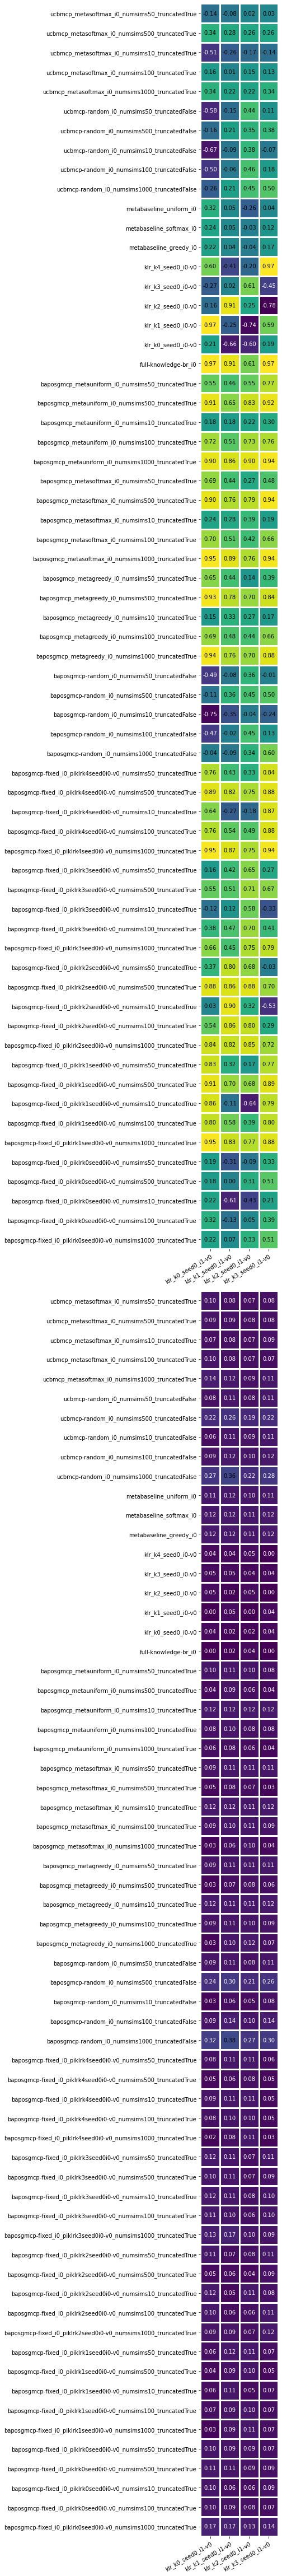

In [16]:
agent_0_df = baposgmcp_combined_df[baposgmcp_combined_df["agent_id"] == 0]
plot_utils.plot_pairwise_comparison(
    agent_0_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    y_err_key="episode_return_CI",
    vrange=None, 
    figsize=(24, len(agent_0_df["policy_id"].unique())), 
    valfmt="{x:.2f}",
    coplayer_policies=list(policy_prior[1]),
    average_duplicates=True,
    duplicate_warning=False
)

/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]
/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]


(<Figure size 1728x4608 with 2 Axes>,
 array([[<AxesSubplot:>],
        [<AxesSubplot:>]], dtype=object))

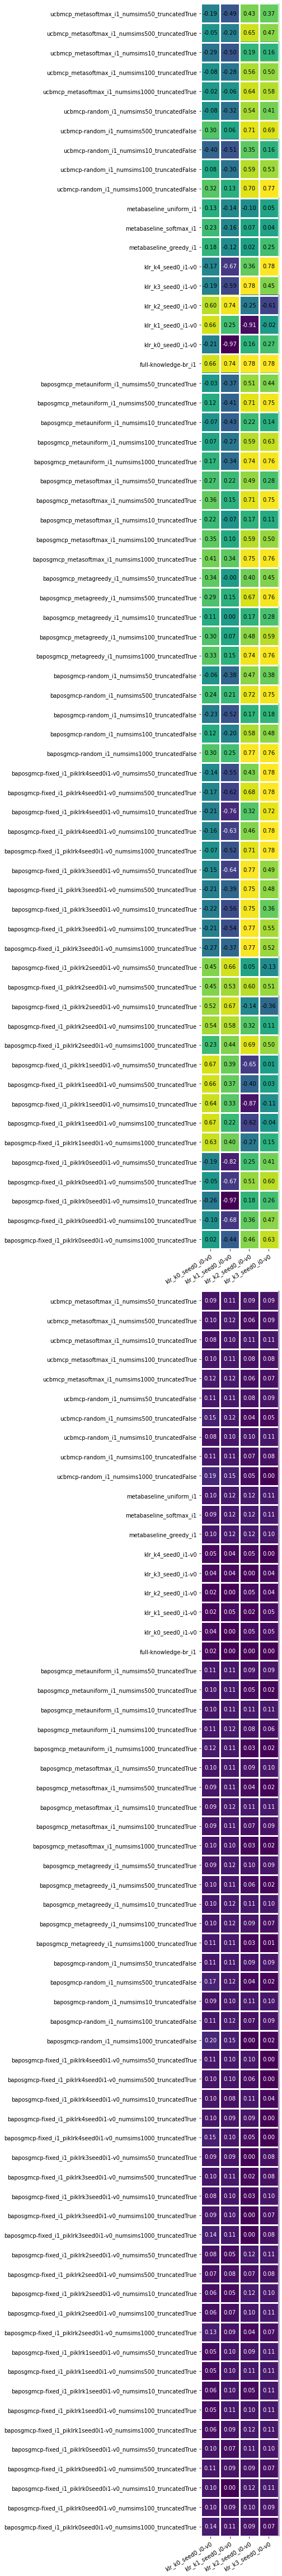

In [17]:
agent_1_df = baposgmcp_combined_df[baposgmcp_combined_df["agent_id"] == 1]
plot_utils.plot_pairwise_comparison(
    agent_1_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    y_err_key="episode_return_CI",
    vrange=None, 
    figsize=(24, len(agent_1_df["policy_id"].unique())), 
    valfmt="{x:.2f}",
    coplayer_policies=list(policy_prior[0]),
    average_duplicates=True,
    duplicate_warning=False
)

/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]


(<Figure size 1728x4608 with 1 Axes>, array([[<AxesSubplot:>]], dtype=object))

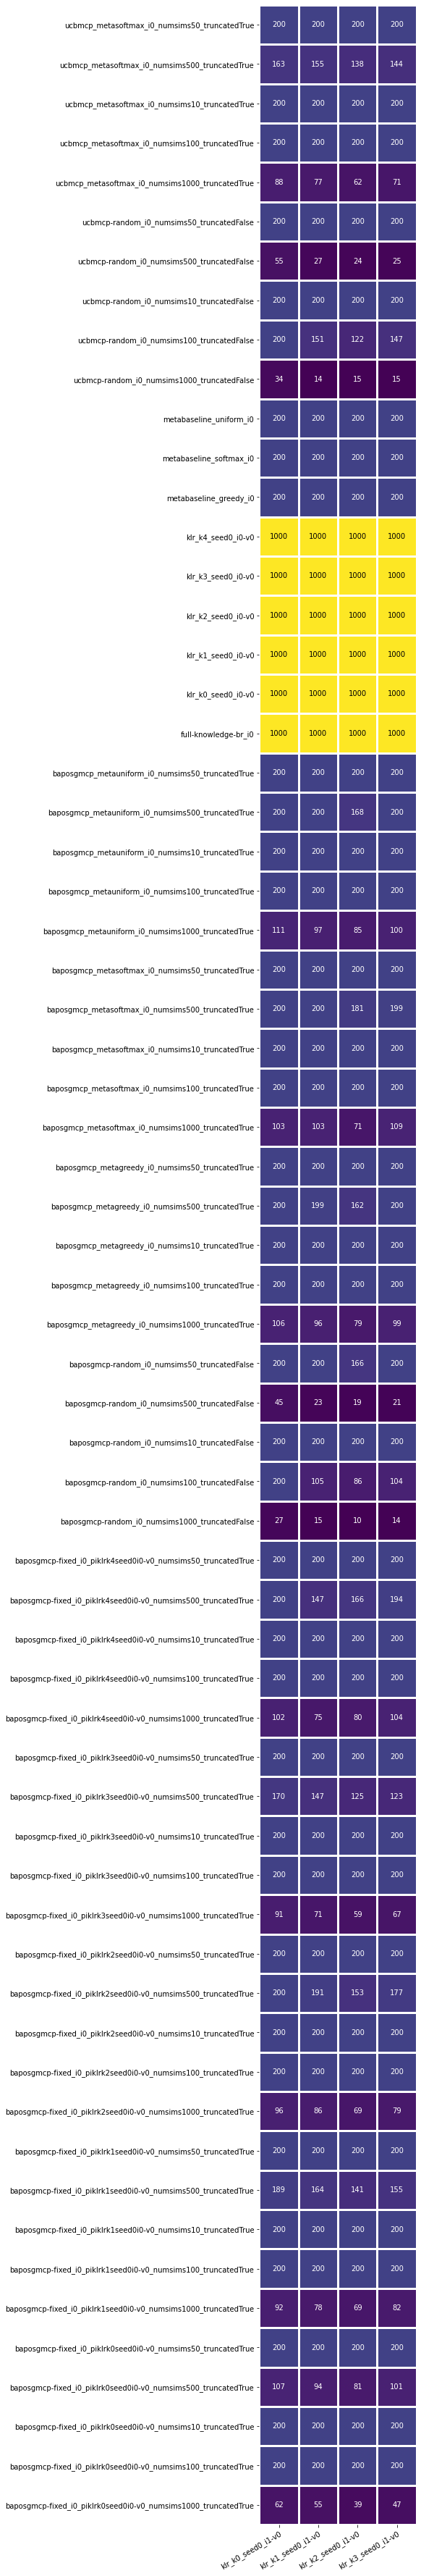

In [18]:
plot_utils.plot_pairwise_comparison(
    agent_0_df,
    y_key="num_episodes", 
    policy_key="policy_id",
    y_err_key=None,
    vrange=None, 
    figsize=(24, len(agent_0_df["policy_id"].unique())),  
    valfmt="{x:.0f}",
    coplayer_policies=list(policy_prior[1]),
    average_duplicates=True,
    duplicate_warning=False
)

/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]


(<Figure size 1728x4608 with 1 Axes>, array([[<AxesSubplot:>]], dtype=object))

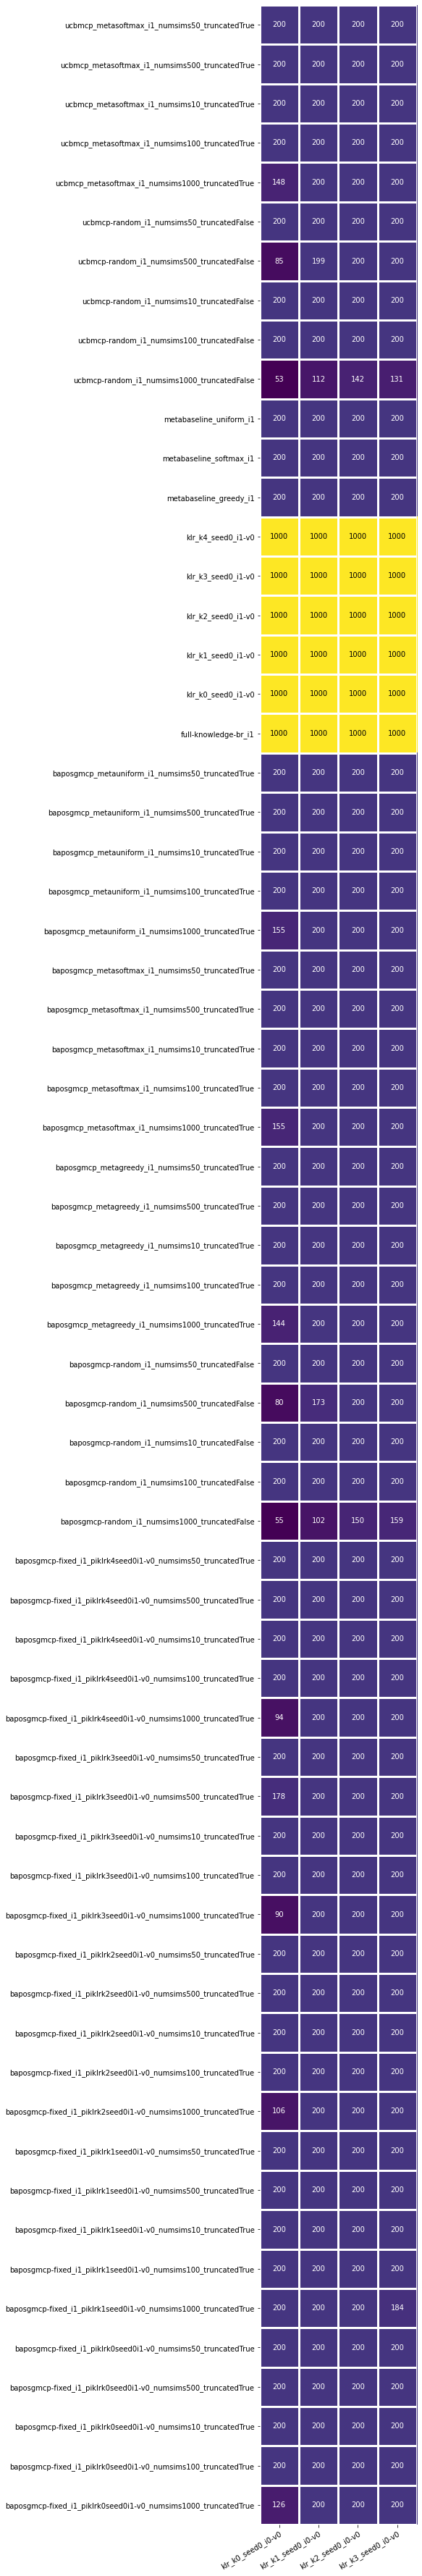

In [19]:
plot_utils.plot_pairwise_comparison(
    agent_1_df,
    y_key="num_episodes", 
    policy_key="policy_id",
    y_err_key=None,
    vrange=None,
    figsize=(24, len(agent_1_df["policy_id"].unique())),  
    valfmt="{x:.0f}",
    coplayer_policies=list(policy_prior[0]),
    average_duplicates=True,
    duplicate_warning=False
)

# Expected Performance

Here we look at the expected performance given the policy prior of BAPOSGMCP and the different baselines.

Specifically:

1. Comparing different meta-policies
2. Comparing performance using meta-policy vs using a single fixed policy
3. Comparing performance between all algorithms

In [20]:
exp_df = plot_utils.get_uniform_expected_df(
    baposgmcp_combined_df, 
    coplayer_policies=coplayer_policy_ids,
    coplayer_policy_key="coplayer_policy_id"
)
exp_df.to_csv(osp.join(BASE_RESULTS_DIR, "sims_expected_performance_results.csv"))

Ungrouped size = 518
Grouped size = 128


In [21]:
time_exp_df = plot_utils.get_uniform_expected_df(
    baposgmcp_time_combined_df, 
    coplayer_policies=coplayer_policy_ids,
    coplayer_policy_key="coplayer_policy_id"
)
time_exp_df.to_csv(osp.join(BASE_RESULTS_DIR, "time_expected_performance_results.csv"))

Ungrouped size = 222
Grouped size = 54


In [22]:
pi_exp_df = plot_utils.get_uniform_expected_df(
    baposgmcp_pi_combined_df, 
    coplayer_policies=coplayer_policy_ids,
    coplayer_policy_key="coplayer_policy_id"
)
pi_exp_df.to_csv(osp.join(BASE_RESULTS_DIR, "pi_expected_performance_results.csv"))

Ungrouped size = 414
Grouped size = 102


In [23]:
# Base plot kwargs
base_plot_kwargs = paper_utils.get_base_plot_kwargs()
return_plot_kwargs = copy.deepcopy(base_plot_kwargs)
return_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Episode Return",
})

step_plot_kwargs = copy.deepcopy(return_plot_kwargs)
step_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Episode Steps"
})

## Comparison of the different Meta-Policies

Here we look at the performance of our algorithm using the difference meta-policies.

Looking at performance with:

- truncated search
- using PUCB

We also look at the performance of the metabaseline with the different meta-policies.

In [24]:
meta_pi_label_map = {
    "greedy": r"$\sigma^{G}$",
    "softmax": r"$\sigma^{S}$",
    "uniform": r"$\sigma^{U}$",
}

meta_pi_df = exp_df[
    (exp_df["action_selection"].isin(["pucb", None]))
    & (
        (exp_df["alg_id"].isin(["metabaseline"]))
        | (
            (exp_df["alg_id"].isin(["baposgmcp"])) & (exp_df["truncated"] == True)
        )
    )
]

meta_alg_ids = meta_pi_df["alg_id"].unique().tolist()
meta_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in meta_alg_ids:
    print(n)
    
policy_ids = meta_pi_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)

Alg IDs
-------
baposgmcp
metabaseline

Policy IDs
----------
baposgmcp_metagreedy_i0_numsims1000_truncatedTrue
baposgmcp_metagreedy_i0_numsims100_truncatedTrue
baposgmcp_metagreedy_i0_numsims10_truncatedTrue
baposgmcp_metagreedy_i0_numsims500_truncatedTrue
baposgmcp_metagreedy_i0_numsims50_truncatedTrue
baposgmcp_metagreedy_i1_numsims1000_truncatedTrue
baposgmcp_metagreedy_i1_numsims100_truncatedTrue
baposgmcp_metagreedy_i1_numsims10_truncatedTrue
baposgmcp_metagreedy_i1_numsims500_truncatedTrue
baposgmcp_metagreedy_i1_numsims50_truncatedTrue
baposgmcp_metasoftmax_i0_numsims1000_truncatedTrue
baposgmcp_metasoftmax_i0_numsims100_truncatedTrue
baposgmcp_metasoftmax_i0_numsims10_truncatedTrue
baposgmcp_metasoftmax_i0_numsims500_truncatedTrue
baposgmcp_metasoftmax_i0_numsims50_truncatedTrue
baposgmcp_metasoftmax_i1_numsims1000_truncatedTrue
baposgmcp_metasoftmax_i1_numsims100_truncatedTrue
baposgmcp_metasoftmax_i1_numsims10_truncatedTrue
baposgmcp_metasoftmax_i1_numsims500_truncatedTrue
b

agent_id=0
alg_id='baposgmcp'
alg_id='metabaseline'
agent_id=1
alg_id='baposgmcp'
alg_id='metabaseline'


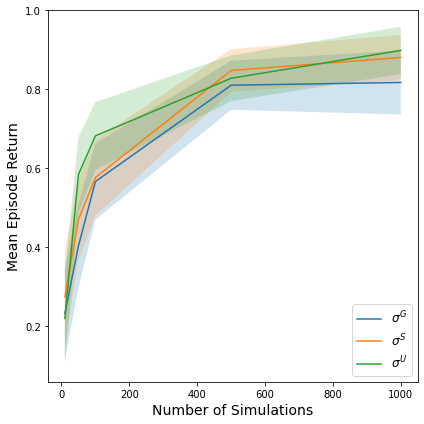

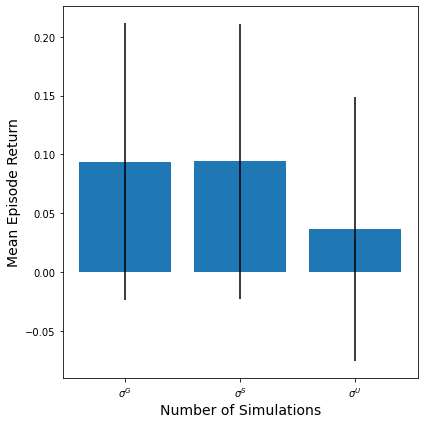

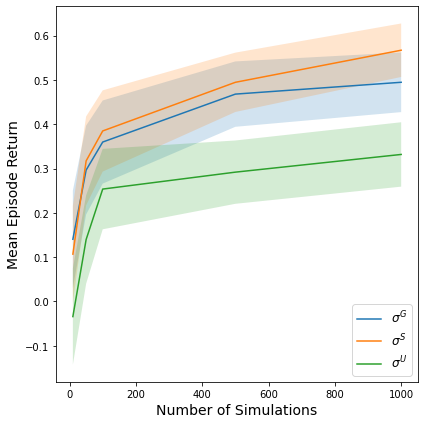

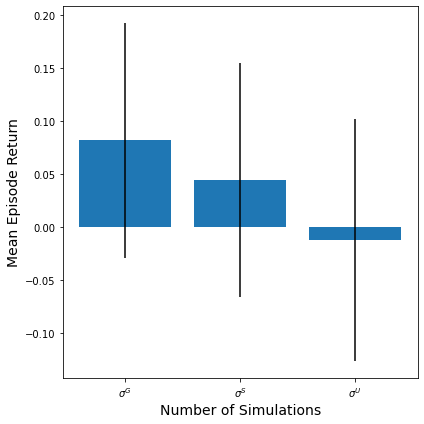

In [25]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    # "ylim": (-1.0, 1.0),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
    # "title": "Meta-Policy" 
})

for agent_id in [0, 1]:
    print(f"{agent_id=}")
    for alg_id in meta_alg_ids:
        print(f"{alg_id=}")
        fig, _ = plot_utils.paper.plot_multiple_meta_policy_performance(
            meta_pi_df[(meta_pi_df["agent_id"] == agent_id) & (meta_pi_df["alg_id"] == alg_id)],
            x_key="num_sims",
            y_key="episode_return_mean",
            y_err_key="episode_return_CI",
            meta_pi_label_map=meta_pi_label_map,
            alg_id_key="alg_id",
            set_title=False,
            **plot_kwargs
        )
        fig.tight_layout()
        fig.savefig(osp.join(figure_dir, f"meta_pi_return_{alg_id}_i{agent_id}.png"))
    
del plot_kwargs

In [26]:
meta_pi_label_map = {
    "greedy": r"$\sigma^{G}$",
    "softmax": r"$\sigma^{S}$",
    "uniform": r"$\sigma^{U}$",
}

meta_pi_df = pi_exp_df[
    (pi_exp_df["action_selection"].isin(["pucb", None]))
    & (pi_exp_df["alg_id"].isin(["baposgmcp"])) & (pi_exp_df["truncated"] == True)
]

meta_alg_ids = meta_pi_df["alg_id"].unique().tolist()
meta_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in meta_alg_ids:
    print(n)
    
policy_ids = meta_pi_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)

Alg IDs
-------
baposgmcp

Policy IDs
----------
baposgmcp_metagreedy_i0_searchtimelimit0.1_truncatedTrue
baposgmcp_metagreedy_i0_searchtimelimit10_truncatedTrue
baposgmcp_metagreedy_i0_searchtimelimit1_truncatedTrue
baposgmcp_metagreedy_i0_searchtimelimit20_truncatedTrue
baposgmcp_metagreedy_i0_searchtimelimit5_truncatedTrue
baposgmcp_metagreedy_i1_searchtimelimit0.1_truncatedTrue
baposgmcp_metagreedy_i1_searchtimelimit10_truncatedTrue
baposgmcp_metagreedy_i1_searchtimelimit1_truncatedTrue
baposgmcp_metagreedy_i1_searchtimelimit20_truncatedTrue
baposgmcp_metagreedy_i1_searchtimelimit5_truncatedTrue
baposgmcp_metasoftmax_i0_searchtimelimit0.1_truncatedTrue
baposgmcp_metasoftmax_i0_searchtimelimit10_truncatedTrue
baposgmcp_metasoftmax_i0_searchtimelimit1_truncatedTrue
baposgmcp_metasoftmax_i0_searchtimelimit20_truncatedTrue
baposgmcp_metasoftmax_i0_searchtimelimit5_truncatedTrue
baposgmcp_metasoftmax_i1_searchtimelimit0.1_truncatedTrue
baposgmcp_metasoftmax_i1_searchtimelimit10_truncate

agent_id=0
alg_id='baposgmcp'
agent_id=1
alg_id='baposgmcp'


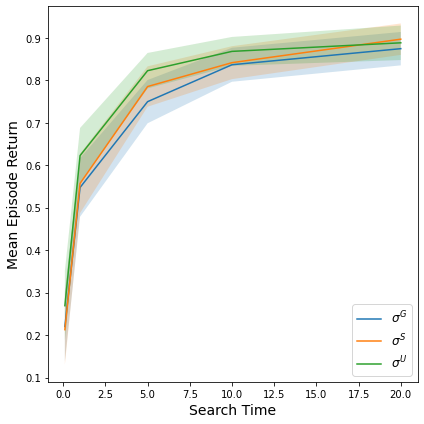

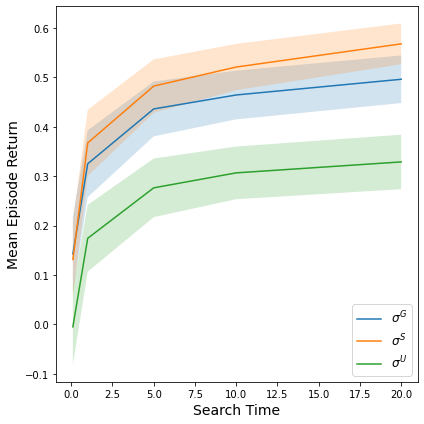

In [27]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "xlabel": "Search Time"
    # "ylim": (-1.0, 1.0),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
    # "title": "Meta-Policy" 
})

for agent_id in [0, 1]:
    print(f"{agent_id=}")
    for alg_id in meta_alg_ids:
        print(f"{alg_id=}")
        fig, _ = plot_utils.paper.plot_multiple_meta_policy_performance(
            meta_pi_df[(meta_pi_df["agent_id"] == agent_id) & (meta_pi_df["alg_id"] == alg_id)],
            x_key="search_time_limit",
            y_key="episode_return_mean",
            y_err_key="episode_return_CI",
            meta_pi_label_map=meta_pi_label_map,
            alg_id_key="alg_id",
            set_title=False,
            **plot_kwargs
        )
        fig.tight_layout()
        fig.savefig(osp.join(figure_dir, f"meta_pi_return_{alg_id}_i{agent_id}.png"))
    
del plot_kwargs

## Comparing Meta-Policy versus no meta-policy (using a single policy)

Here we look at the performance of BAPOSGMCP with a meta-policy against not using a meta-policy (i.e. using the different fixed policies).

Parameters:

- Truncated search (except for random)
- using PUCB

In [28]:
# TODO May need to change BAPOSGMCP meta policy depending on results
# BAPOSGMCP Meta-Policy
# 0: Best = uniform (but only marginally at lower #sims (i.e. 100))
#           Performance is roughly equal between all meta Pis at higher sims >=500
# 1: Best = clearly softmax > greedy > uniform
#
# Hence I use softmax for remainder of analysis

meta_vs_no_pi_label_map = {
    0: {
        # "baposgmcp_uniform": r"$\sigma^{U}$",
        "baposgmcp_metasoftmax": r"$\sigma^{S}$",
        "baposgmcp-random_i0": "Random",
        "baposgmcp-fixed_i0_piklrk0seed0i0-v0": "K0_0",
        "baposgmcp-fixed_i0_piklrk1seed0i0-v0": "K1_0",
        "baposgmcp-fixed_i0_piklrk2seed0i0-v0": "K2_0",
        "baposgmcp-fixed_i0_piklrk3seed0i0-v0": "K3_0",
    },
    1: {
        # "baposgmcp_uniform": r"$\sigma^{U}$",
        "baposgmcp_metasoftmax": r"$\sigma^{S}$",
        "baposgmcp-random_i1": "Random",
        "baposgmcp-fixed_i1_piklrk0seed0i1-v0": "K0_1",
        "baposgmcp-fixed_i1_piklrk1seed0i1-v0": "K1_1",
        "baposgmcp-fixed_i1_piklrk2seed0i1-v0": "K2_1",
        "baposgmcp-fixed_i1_piklrk3seed0i1-v0": "K3_1",
    }
}

# Use DF containing only policies with PUCB action_selection or NA
meta_vs_no_meta_df = exp_df[
    (exp_df["alg_id"].isin(["baposgmcp", "baposgmcp-fixed", "baposgmcp-random"]))
    & (exp_df["action_selection"].isin(["pucb"]))
    & (exp_df["meta_pi"].isin(["softmax", "NA"]))
    & (
        ((exp_df["alg_id"] == "baposgmcp-random") & (exp_df["truncated"] == False))
        | ((exp_df["alg_id"].isin(["baposgmcp", "baposgmcp-fixed"])) & (exp_df["truncated"] == True))
    )
]

meta_vs_no_meta_alg_ids = meta_vs_no_meta_df["alg_id"].unique().tolist()
meta_vs_no_meta_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in meta_vs_no_meta_alg_ids:
    print(n)
    
policy_ids = meta_vs_no_meta_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)
    
fixed_policy_ids = meta_vs_no_meta_df["fixed_policy_id"].unique().tolist()
print("\nFixed Policy IDs")
print("----------------")
for n in fixed_policy_ids:
    print(n)

Alg IDs
-------
baposgmcp
baposgmcp-fixed
baposgmcp-random

Policy IDs
----------
baposgmcp-fixed_i0_piklrk0seed0i0-v0_numsims1000_truncatedTrue
baposgmcp-fixed_i0_piklrk0seed0i0-v0_numsims100_truncatedTrue
baposgmcp-fixed_i0_piklrk0seed0i0-v0_numsims10_truncatedTrue
baposgmcp-fixed_i0_piklrk0seed0i0-v0_numsims500_truncatedTrue
baposgmcp-fixed_i0_piklrk0seed0i0-v0_numsims50_truncatedTrue
baposgmcp-fixed_i0_piklrk1seed0i0-v0_numsims1000_truncatedTrue
baposgmcp-fixed_i0_piklrk1seed0i0-v0_numsims100_truncatedTrue
baposgmcp-fixed_i0_piklrk1seed0i0-v0_numsims10_truncatedTrue
baposgmcp-fixed_i0_piklrk1seed0i0-v0_numsims500_truncatedTrue
baposgmcp-fixed_i0_piklrk1seed0i0-v0_numsims50_truncatedTrue
baposgmcp-fixed_i0_piklrk2seed0i0-v0_numsims1000_truncatedTrue
baposgmcp-fixed_i0_piklrk2seed0i0-v0_numsims100_truncatedTrue
baposgmcp-fixed_i0_piklrk2seed0i0-v0_numsims10_truncatedTrue
baposgmcp-fixed_i0_piklrk2seed0i0-v0_numsims500_truncatedTrue
baposgmcp-fixed_i0_piklrk2seed0i0-v0_numsims50_trunc

agent_id=0
agent_id=1


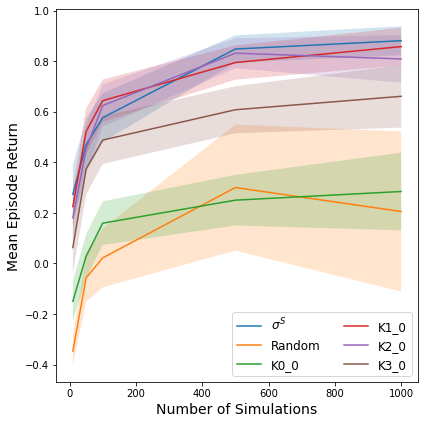

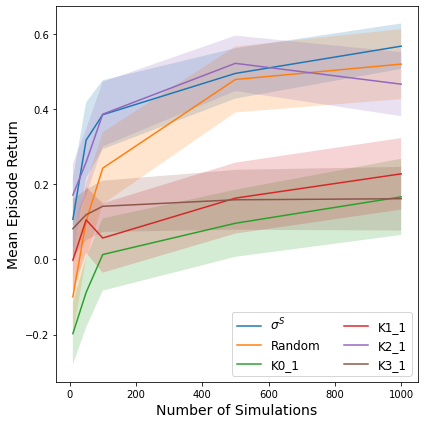

In [29]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    # "ylim": (-0.5, 1.0),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
    # "title": "Policy",
    "ncol": 2
})

for agent_id in [0, 1]:
    print(f"{agent_id=}")
    fig, _ = plot_utils.paper.plot_multiple_performance(
        meta_vs_no_meta_df[meta_vs_no_meta_df["agent_id"] == agent_id],
        x_key="num_sims",
        y_key="episode_return_mean",
        y_err_key="episode_return_CI",
        policy_prefixes=[list(meta_vs_no_pi_label_map[agent_id])],
        pi_label_map=meta_vs_no_pi_label_map[agent_id],
        constant_policy_prefixes=[],
        **plot_kwargs,
    )
    
    fig.tight_layout()
    fig.savefig(osp.join(figure_dir, f"meta_vs_fixed_return_i{agent_id}.png"))
    
del plot_kwargs

agent_id=0
agent_id=1


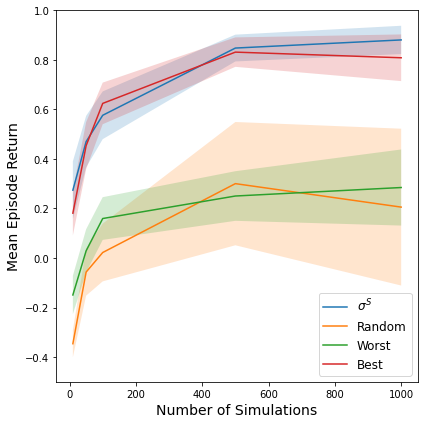

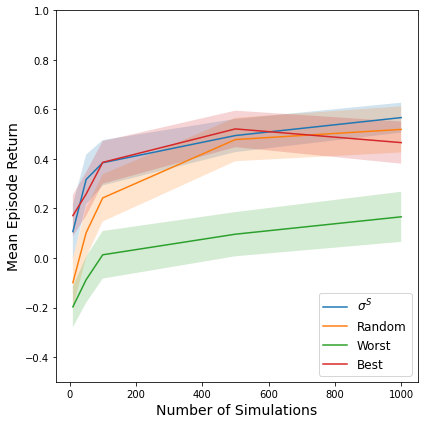

In [30]:
meta_vs_no_best_and_worst_pi_label_map = {
    0: {
        # "baposgmcp_uniform": r"$\sigma^{U}$",
        "baposgmcp_metasoftmax": r"$\sigma^{S}$",
        "baposgmcp-random_i0": "Random",
        "baposgmcp-fixed_i0_piklrk0seed0i0-v0": "Worst",
        #"baposgmcp-fixed_i0_piklrk1seed0i0-v0": "K1_0",
        "baposgmcp-fixed_i0_piklrk2seed0i0-v0": "Best",
        # "baposgmcp-fixed_i0_piklrk3seed0i0-v0": "K3_0",
    },
    1: {
        # "baposgmcp_uniform": r"$\sigma^{U}$",
        "baposgmcp_metasoftmax": r"$\sigma^{S}$",
        "baposgmcp-random_i1": "Random",
        "baposgmcp-fixed_i1_piklrk0seed0i1-v0": "Worst",
        # "baposgmcp-fixed_i1_piklrk1seed0i1-v0": "K1_1",
        "baposgmcp-fixed_i1_piklrk2seed0i1-v0": "Best",
        # "baposgmcp-fixed_i1_piklrk3seed0i1-v0": "K3_1",
    }
}

plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (-0.5, 1.0),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
    # "title": "Policy" 
})

for agent_id in [0, 1]:
    print(f"{agent_id=}")
    fig, _ = plot_utils.paper.plot_multiple_performance(
        meta_vs_no_meta_df[meta_vs_no_meta_df["agent_id"] == agent_id],
        x_key="num_sims",
        y_key="episode_return_mean",
        y_err_key="episode_return_CI",
        policy_prefixes=[list(meta_vs_no_best_and_worst_pi_label_map[agent_id])],
        pi_label_map=meta_vs_no_best_and_worst_pi_label_map[agent_id],
        constant_policy_prefixes=[],
        **plot_kwargs,
    )
    
    fig.tight_layout()
    fig.savefig(osp.join(figure_dir, f"meta_vs_fixed_return_best_and_worst_i{agent_id}.png"))
    
del plot_kwargs

In [31]:
# Use DF containing only policies with PUCB action_selection or NA
meta_vs_no_meta_df = pi_exp_df[
    (pi_exp_df["alg_id"].isin(["baposgmcp", "baposgmcp-fixed", "baposgmcp-random"]))
    & (pi_exp_df["action_selection"].isin(["pucb"]))
    & (pi_exp_df["meta_pi"].isin(["softmax", "NA"]))
    & (
        ((pi_exp_df["alg_id"] == "baposgmcp-random") & (pi_exp_df["truncated"] == False))
        | ((pi_exp_df["alg_id"].isin(["baposgmcp", "baposgmcp-fixed"])) & (pi_exp_df["truncated"] == True))
    )
]

meta_vs_no_meta_alg_ids = meta_vs_no_meta_df["alg_id"].unique().tolist()
meta_vs_no_meta_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in meta_vs_no_meta_alg_ids:
    print(n)
    
policy_ids = meta_vs_no_meta_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)
    
fixed_policy_ids = meta_vs_no_meta_df["fixed_policy_id"].unique().tolist()
print("\nFixed Policy IDs")
print("----------------")
for n in fixed_policy_ids:
    print(n)

Alg IDs
-------
baposgmcp
baposgmcp-fixed
baposgmcp-random

Policy IDs
----------
baposgmcp-fixed_i0_piklrk0seed0i0-v0_searchtimelimit0.1_truncatedTrue
baposgmcp-fixed_i0_piklrk0seed0i0-v0_searchtimelimit10_truncatedTrue
baposgmcp-fixed_i0_piklrk0seed0i0-v0_searchtimelimit1_truncatedTrue
baposgmcp-fixed_i0_piklrk0seed0i0-v0_searchtimelimit20_truncatedTrue
baposgmcp-fixed_i0_piklrk0seed0i0-v0_searchtimelimit5_truncatedTrue
baposgmcp-fixed_i0_piklrk1seed0i0-v0_searchtimelimit0.1_truncatedTrue
baposgmcp-fixed_i0_piklrk1seed0i0-v0_searchtimelimit10_truncatedTrue
baposgmcp-fixed_i0_piklrk1seed0i0-v0_searchtimelimit1_truncatedTrue
baposgmcp-fixed_i0_piklrk1seed0i0-v0_searchtimelimit20_truncatedTrue
baposgmcp-fixed_i0_piklrk1seed0i0-v0_searchtimelimit5_truncatedTrue
baposgmcp-fixed_i0_piklrk2seed0i0-v0_searchtimelimit0.1_truncatedTrue
baposgmcp-fixed_i0_piklrk2seed0i0-v0_searchtimelimit10_truncatedTrue
baposgmcp-fixed_i0_piklrk2seed0i0-v0_searchtimelimit1_truncatedTrue
baposgmcp-fixed_i0_pikl

agent_id=0
agent_id=1


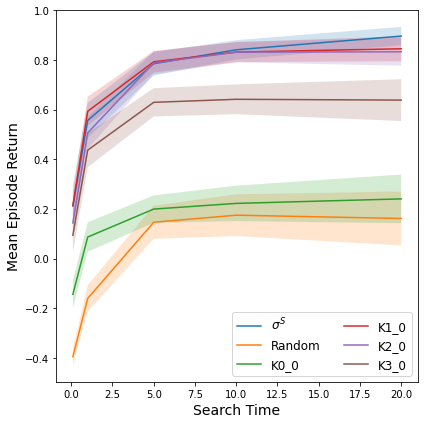

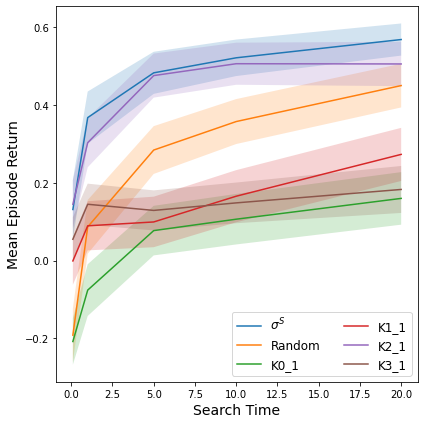

In [32]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "xlabel": "Search Time"
    # "ylim": (-0.5, 1.0),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
    # "title": "Policy",
    "ncol": 2
})

for agent_id in [0, 1]:
    print(f"{agent_id=}")
    fig, _ = plot_utils.paper.plot_multiple_performance(
        meta_vs_no_meta_df[meta_vs_no_meta_df["agent_id"] == agent_id],
        x_key="search_time_limit",
        y_key="episode_return_mean",
        y_err_key="episode_return_CI",
        policy_prefixes=[list(meta_vs_no_pi_label_map[agent_id])],
        pi_label_map=meta_vs_no_pi_label_map[agent_id],
        constant_policy_prefixes=[],
        **plot_kwargs,
    )
    
    fig.tight_layout()
    fig.savefig(osp.join(figure_dir, f"meta_vs_fixed_return_i{agent_id}.png"))
    
del plot_kwargs

agent_id=0
agent_id=1


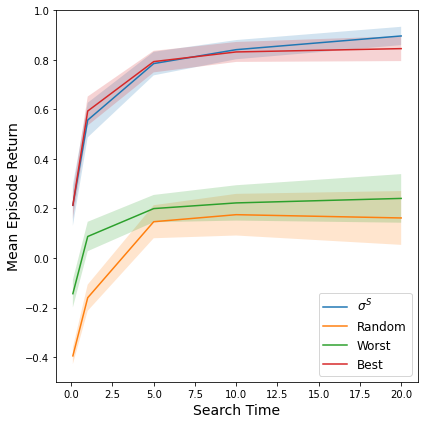

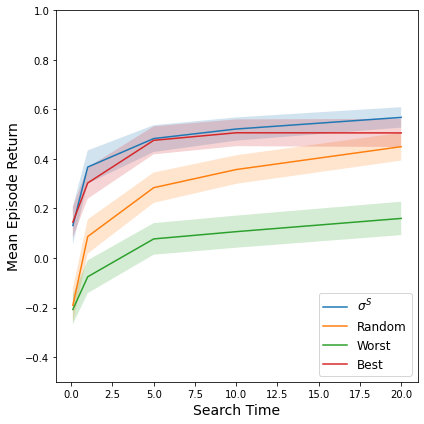

In [33]:
meta_vs_no_best_and_worst_pi_label_map = {
    0: {
        "baposgmcp_metasoftmax": r"$\sigma^{S}$",
        "baposgmcp-random_i0": "Random",
        "baposgmcp-fixed_i0_piklrk0seed0i0-v0": "Worst",
        "baposgmcp-fixed_i0_piklrk1seed0i0-v0": "Best",
        # "baposgmcp-fixed_i0_piklrk2seed0i0-v0": "Best",
        # "baposgmcp-fixed_i0_piklrk3seed0i0-v0": "K3_0",
    },
    1: {
        "baposgmcp_metasoftmax": r"$\sigma^{S}$",
        "baposgmcp-random_i1": "Random",
        "baposgmcp-fixed_i1_piklrk0seed0i1-v0": "Worst",
        # "baposgmcp-fixed_i1_piklrk1seed0i1-v0": "K1_1",
        "baposgmcp-fixed_i1_piklrk2seed0i1-v0": "Best",
        # "baposgmcp-fixed_i1_piklrk3seed0i1-v0": "K3_1",
    }
}

plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "xlabel": "Search Time",
    "ylim": (-0.5, 1.0),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
    # "title": "Policy" 
})

for agent_id in [0, 1]:
    print(f"{agent_id=}")
    fig, _ = plot_utils.paper.plot_multiple_performance(
        meta_vs_no_meta_df[meta_vs_no_meta_df["agent_id"] == agent_id],
        x_key="search_time_limit",
        y_key="episode_return_mean",
        y_err_key="episode_return_CI",
        policy_prefixes=[list(meta_vs_no_best_and_worst_pi_label_map[agent_id])],
        pi_label_map=meta_vs_no_best_and_worst_pi_label_map[agent_id],
        constant_policy_prefixes=[],
        **plot_kwargs,
    )
    
    fig.tight_layout()
    fig.savefig(osp.join(figure_dir, f"meta_vs_fixed_return_best_and_worst_i{agent_id}.png"))
    
del plot_kwargs

## Comparing BAPOSGMCP versus baselines

Finally we compare BAPOSGMCP versus baselines. Specifically we compare:

- BAPOSGMCP (PUCB + Best Meta)
- IPOMCP-Meta (UCB + Best Meta)
- IPOMCP (UCB + Random)
- Full Knowledge BR
- Meta

In [34]:
best_meta_pi = "softmax"
perf_df = exp_df[
    (exp_df["alg_id"] == "full-knowledge-br")
    | ((exp_df["alg_id"] == "metabaseline") & (exp_df["meta_pi"] == best_meta_pi))
    | ((exp_df["alg_id"] == "baposgmcp") & (exp_df["meta_pi"] == best_meta_pi) & (exp_df["truncated"] == True))
    | ((exp_df["alg_id"] == "baposgmcp-random") & (exp_df["truncated"] == False))
    | ((exp_df["alg_id"] == "ucbmcp") & (exp_df["meta_pi"] == best_meta_pi) & (exp_df["truncated"] == True))
    | ((exp_df["alg_id"] == "ucbmcp-random") & (exp_df["truncated"] == False))
]

baseline_policy_prefixes_to_plot = [
    f"baposgmcp_meta{best_meta_pi}",
    # "baposgmcp-random",
    "ucbmcp-random",
    f"ucbmcp_meta{best_meta_pi}",
    f"metabaseline_{best_meta_pi}",
    f"full-knowledge-br",
]
constant_policy_prefixes=[
    f"metabaseline_{best_meta_pi}",
    f"full-knowledge-br",
]

baseline_pi_label_map = {
    f"baposgmcp_meta{best_meta_pi}": algname,
    # "baposgmcp-random": f"{algname} + Random", 
    "full-knowledge-br": "Best-Response",
    f"metabaseline_{best_meta_pi}": "Meta-Policy",
    f"ucbmcp_meta{best_meta_pi}": f"{baselinealgname} + Meta",
    "ucbmcp-random": f"{baselinealgname} + Random"
}

perf_ids = perf_df["alg_id"].unique().tolist()
perf_ids.sort()
print("Alg IDs")
print("-------")
for n in perf_ids:
    print(n)
    
policy_ids = perf_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)

Alg IDs
-------
baposgmcp
baposgmcp-random
full-knowledge-br
metabaseline
ucbmcp
ucbmcp-random

Policy IDs
----------
baposgmcp-random_i0_numsims1000_truncatedFalse
baposgmcp-random_i0_numsims100_truncatedFalse
baposgmcp-random_i0_numsims10_truncatedFalse
baposgmcp-random_i0_numsims500_truncatedFalse
baposgmcp-random_i0_numsims50_truncatedFalse
baposgmcp-random_i1_numsims1000_truncatedFalse
baposgmcp-random_i1_numsims100_truncatedFalse
baposgmcp-random_i1_numsims10_truncatedFalse
baposgmcp-random_i1_numsims500_truncatedFalse
baposgmcp-random_i1_numsims50_truncatedFalse
baposgmcp_metasoftmax_i0_numsims1000_truncatedTrue
baposgmcp_metasoftmax_i0_numsims100_truncatedTrue
baposgmcp_metasoftmax_i0_numsims10_truncatedTrue
baposgmcp_metasoftmax_i0_numsims500_truncatedTrue
baposgmcp_metasoftmax_i0_numsims50_truncatedTrue
baposgmcp_metasoftmax_i1_numsims1000_truncatedTrue
baposgmcp_metasoftmax_i1_numsims100_truncatedTrue
baposgmcp_metasoftmax_i1_numsims10_truncatedTrue
baposgmcp_metasoftmax_i1_

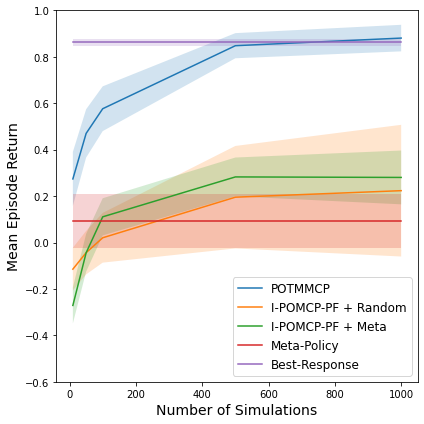

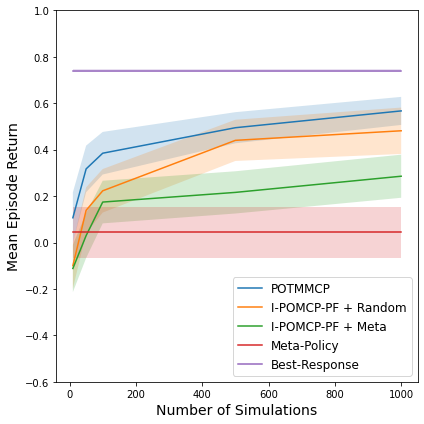

In [35]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (-0.6, 1.0),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
})

for agent_id in [0, 1]:
    fig, _ = plot_utils.paper.plot_multiple_performance(
        perf_df[perf_df["agent_id"] == agent_id],
        x_key="num_sims",
        y_key="episode_return_mean",
        y_err_key="episode_return_CI",
        policy_prefixes=[baseline_policy_prefixes_to_plot],
        pi_label_map=baseline_pi_label_map,
        constant_policy_prefixes=constant_policy_prefixes,
        **plot_kwargs,
    )
    
    fig.tight_layout()
    fig.savefig(osp.join(figure_dir, f"baselines_return_i{agent_id}.png"))
    
del plot_kwargs

## Performance vs search time

In [36]:
best_meta_pi = "softmax"
time_perf_df = time_exp_df[
    (time_exp_df["alg_id"] == "full-knowledge-br")
    | ((time_exp_df["alg_id"] == "metabaseline") & (time_exp_df["meta_pi"] == best_meta_pi))
    | ((time_exp_df["alg_id"] == "baposgmcp") & (time_exp_df["meta_pi"] == best_meta_pi) & (time_exp_df["truncated"] == True))
    | ((time_exp_df["alg_id"] == "baposgmcp-random") & (time_exp_df["truncated"] == False))
    | ((time_exp_df["alg_id"] == "ucbmcp") & (time_exp_df["meta_pi"] == best_meta_pi) & (time_exp_df["truncated"] == True))
    | ((time_exp_df["alg_id"] == "ucbmcp-random") & (time_exp_df["truncated"] == False))
]

time_baseline_policy_prefixes_to_plot = [
    f"baposgmcp_meta{best_meta_pi}",
    # "baposgmcp-random",
    "ucbmcp-random",
    f"ucbmcp_meta{best_meta_pi}",
    f"metabaseline_{best_meta_pi}",
    f"full-knowledge-br",
]
constant_policy_prefixes = [
    f"metabaseline_{best_meta_pi}",
    f"full-knowledge-br",
]

time_baseline_pi_label_map = {
    f"baposgmcp_meta{best_meta_pi}": algname,
    # "baposgmcp-random": f"{algname} + Random", 
    "full-knowledge-br": "Best-Response",
    f"metabaseline_{best_meta_pi}": "Meta-Policy",
    f"ucbmcp_meta{best_meta_pi}": f"{baselinealgname} + Meta",
    "ucbmcp-random": f"{baselinealgname} + Random"
}

time_perf_ids = time_perf_df["alg_id"].unique().tolist()
time_perf_ids.sort()
print("Alg IDs")
print("-------")
for n in time_perf_ids:
    print(n)
    
time_policy_ids = time_perf_df["policy_id"].unique().tolist()
time_policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in time_policy_ids:
    print(n)

Alg IDs
-------
baposgmcp
baposgmcp-random
full-knowledge-br
metabaseline
ucbmcp
ucbmcp-random

Policy IDs
----------
baposgmcp-random_i0_searchtimelimit0.1_truncatedFalse
baposgmcp-random_i0_searchtimelimit10_truncatedFalse
baposgmcp-random_i0_searchtimelimit1_truncatedFalse
baposgmcp-random_i0_searchtimelimit20_truncatedFalse
baposgmcp-random_i0_searchtimelimit5_truncatedFalse
baposgmcp-random_i1_searchtimelimit0.1_truncatedFalse
baposgmcp-random_i1_searchtimelimit10_truncatedFalse
baposgmcp-random_i1_searchtimelimit1_truncatedFalse
baposgmcp-random_i1_searchtimelimit20_truncatedFalse
baposgmcp-random_i1_searchtimelimit5_truncatedFalse
baposgmcp_metasoftmax_i0_searchtimelimit0.1_truncatedTrue
baposgmcp_metasoftmax_i0_searchtimelimit10_truncatedTrue
baposgmcp_metasoftmax_i0_searchtimelimit1_truncatedTrue
baposgmcp_metasoftmax_i0_searchtimelimit20_truncatedTrue
baposgmcp_metasoftmax_i0_searchtimelimit5_truncatedTrue
baposgmcp_metasoftmax_i1_searchtimelimit0.1_truncatedTrue
baposgmcp_me

agent_id=0
agent_id=1


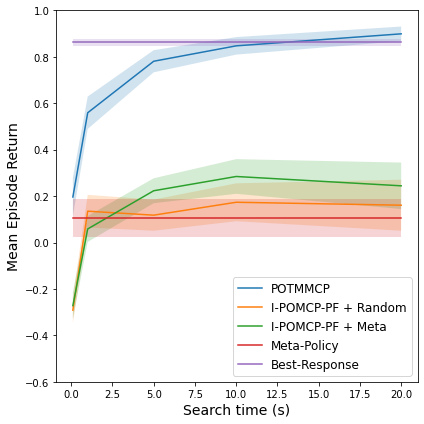

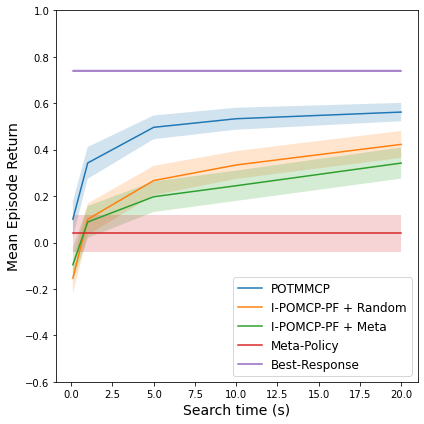

In [37]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "xlabel": "Search time (s)",
    "ylim": (-0.6, 1.0),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
})

for agent_id in [0, 1]:
    print(f"{agent_id=}")
    fig, _ = plot_utils.paper.plot_multiple_performance(
        time_perf_df[time_perf_df["agent_id"] == agent_id],
        x_key="search_time_limit",
        y_key="episode_return_mean",
        y_err_key="episode_return_CI",
        policy_prefixes=[time_baseline_policy_prefixes_to_plot],
        pi_label_map=time_baseline_pi_label_map,
        constant_policy_prefixes=constant_policy_prefixes,
        **plot_kwargs,
    )

    fig.tight_layout()
    fig.savefig(osp.join(figure_dir, f"baselines_return_vs_search_time_i{agent_id}.png"))
    
del plot_kwargs

# Analysis

Here we take a deeper dive into the characteristics of BA-POSGMCP. Specifically looking at:

1. Belief accuracy
2. Planning time

## Looking at Belief accuracy by steps

- action_dist_distance
- bayes_accuracy

In [38]:
belief_df = time_exp_df[
    (time_exp_df["alg_id"] == "baposgmcp") 
    & (time_exp_df["truncated"] == True)
    & (time_exp_df["action_selection"] == "pucb")
]


belief_alg_ids = belief_df["alg_id"].unique().tolist()
belief_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in belief_alg_ids:
    print(n)

# group over meta-policy values
belief_group_keys = ["alg_id", "search_time_limit"]
belief_agg_dict = plot_utils.get_uniform_expected_agg_map(exp_df)
belief_df_cols = set(belief_df.columns)
keys_to_drop = []
for k in belief_agg_dict:
    if k not in belief_df_cols or k in belief_group_keys:
        keys_to_drop.append(k)

for k in keys_to_drop:
    belief_agg_dict.pop(k)  
        
gb = belief_df.groupby(belief_group_keys)
gb_agg = gb.agg(**belief_agg_dict)
belief_gb_df = gb_agg.reset_index()

belief_gb_df.sort_values(by=["search_time_limit"], inplace=True)

print("Ungrouped size =", len(belief_df))
print("Grouped size =", len(belief_gb_df))
print(belief_gb_df)

Alg IDs
-------
baposgmcp
Ungrouped size = 10
Grouped size = 5
      alg_id  search_time_limit  exp_id  exp_seed  coplayer_policy_id  \
0  baposgmcp                0.1       0         0  klr_k0_seed0_i1-v0   
1  baposgmcp                1.0       4         0  klr_k0_seed0_i1-v0   
2  baposgmcp                5.0       8         0  klr_k0_seed0_i1-v0   
3  baposgmcp               10.0      12         0  klr_k0_seed0_i1-v0   
4  baposgmcp               20.0      16         0  klr_k0_seed0_i1-v0   

   agent_id                  env_id time_limit  episode_step_limit discount  \
0         0  PursuitEvasion16x16-v0      43200               100.0     0.99   
1         0  PursuitEvasion16x16-v0      43200               100.0     0.99   
2         0  PursuitEvasion16x16-v0      43200               100.0     0.99   
3         0  PursuitEvasion16x16-v0      43200               100.0     0.99   
4         0  PursuitEvasion16x16-v0      43200               100.0     0.99   

   ... bayes_accuracy_1

agent_id=0
agent_id=1


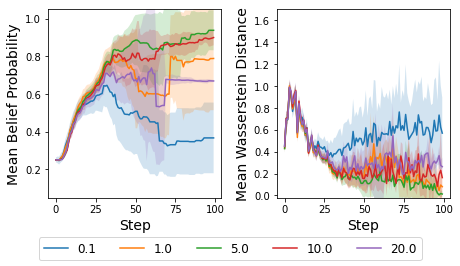

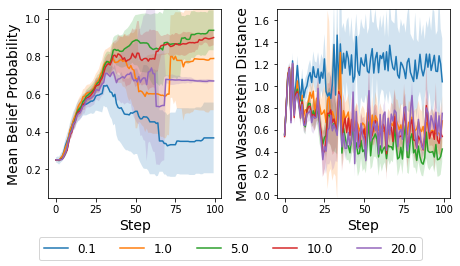

In [39]:
fig_kwargs = {"figsize": (paper_utils.PAGE_COL_WIDTH*2, 3.7)}
subplot_kwargs = {
    "xlabel": "Step"
}

for (i, j) in [(0, 1), (1, 0)]:
    print(f"agent_id={i}")
    num_rows = 1
    num_cols = 2
    fig, axs = plt.subplots(
        nrows=num_rows,
        ncols=num_cols,
        squeeze=True,
        subplot_kw=subplot_kwargs,
        **fig_kwargs,
    )

    y_lims = [(0.05, 1.05), (-0.02, 1.7)]
    y_labels = ["Mean Belief Probability", "Mean Wasserstein Distance"]

    plot_utils.paper.plot_expected_belief_stat_by_step(
        belief_gb_df,
        axs[0],
        z_key="search_time_limit",
        y_key_prefix="bayes_accuracy",
        step_limit=100,
        other_agent_id=1,
        y_suffix="mean",
        y_err_suffix="CI",
    )
    axs[0].set_ylabel(y_labels[0])
    axs[0].set_ylim(y_lims[0])

    plot_utils.paper.plot_expected_belief_stat_by_step(
        belief_gb_df,
        axs[1],
        z_key="search_time_limit",
        y_key_prefix="action_dist_distance",
        step_limit=100,
        other_agent_id=j,
        y_suffix="mean",
        y_err_suffix="CI",
    )
    axs[1].set_ylabel(y_labels[1])
    axs[1].set_ylim(y_lims[1])

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, ncol=5, loc="lower center")

    fig.tight_layout(rect=(0.0, 0.08, 1.0, 1.0))
    fig.savefig(osp.join(figure_dir, f"bayes_accuracy_i{i}.png"))
    
del fig_kwargs
del subplot_kwargs

## Looking at time

   - search_time
   - update_time
   - reinvigoration_time
   - policy_calls
   - inference_time
   - search_depth

In [40]:
best_meta_pi = "softmax"
search_time_df = time_exp_df[
    ((time_exp_df["alg_id"] == "baposgmcp") & (time_exp_df["meta_pi"] == best_meta_pi) & (time_exp_df["truncated"] == True))
    | ((time_exp_df["alg_id"] == "ucbmcp") & (time_exp_df["meta_pi"] == best_meta_pi) & (time_exp_df["truncated"] == True))
    | ((time_exp_df["alg_id"] == "ucbmcp-random") & (time_exp_df["truncated"] == False))
]

policy_prefixes_to_plot = [
    f"baposgmcp_meta{best_meta_pi}",
    "ucbmcp-random",
    f"ucbmcp_meta{best_meta_pi}"
]

baseline_pi_label_map = {
    f"baposgmcp_meta{best_meta_pi}": algname,
    f"ucbmcp_meta{best_meta_pi}": f"{baselinealgname} + Meta",
    "ucbmcp-random": f"{baselinealgname} + Random"
}


times_alg_ids = search_time_df["alg_id"].unique().tolist()
times_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in times_alg_ids:
    print(n)
    
times_policy_ids = search_time_df["policy_id"].unique().tolist()
times_policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in times_policy_ids:
    print(n)

Alg IDs
-------
baposgmcp
ucbmcp
ucbmcp-random

Policy IDs
----------
baposgmcp_metasoftmax_i0_searchtimelimit0.1_truncatedTrue
baposgmcp_metasoftmax_i0_searchtimelimit10_truncatedTrue
baposgmcp_metasoftmax_i0_searchtimelimit1_truncatedTrue
baposgmcp_metasoftmax_i0_searchtimelimit20_truncatedTrue
baposgmcp_metasoftmax_i0_searchtimelimit5_truncatedTrue
baposgmcp_metasoftmax_i1_searchtimelimit0.1_truncatedTrue
baposgmcp_metasoftmax_i1_searchtimelimit10_truncatedTrue
baposgmcp_metasoftmax_i1_searchtimelimit1_truncatedTrue
baposgmcp_metasoftmax_i1_searchtimelimit20_truncatedTrue
baposgmcp_metasoftmax_i1_searchtimelimit5_truncatedTrue
ucbmcp-random_i0_searchtimelimit0.1_truncatedFalse
ucbmcp-random_i0_searchtimelimit10_truncatedFalse
ucbmcp-random_i0_searchtimelimit1_truncatedFalse
ucbmcp-random_i0_searchtimelimit20_truncatedFalse
ucbmcp-random_i0_searchtimelimit5_truncatedFalse
ucbmcp-random_i1_searchtimelimit0.1_truncatedFalse
ucbmcp-random_i1_searchtimelimit10_truncatedFalse
ucbmcp-rando

y_key='episode_steps' agent_id=0
y_key='episode_steps' agent_id=1
y_key='search_time' agent_id=0
y_key='search_time' agent_id=1
y_key='evaluation_time' agent_id=0
y_key='evaluation_time' agent_id=1
y_key='inference_time' agent_id=0
y_key='inference_time' agent_id=1
y_key='update_time' agent_id=0
y_key='update_time' agent_id=1
y_key='reinvigoration_time' agent_id=0
y_key='reinvigoration_time' agent_id=1
y_key='search_depth' agent_id=0
y_key='search_depth' agent_id=1


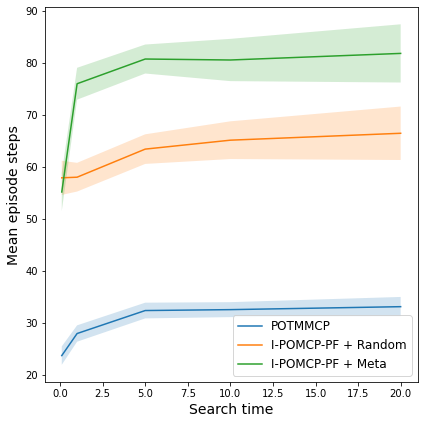

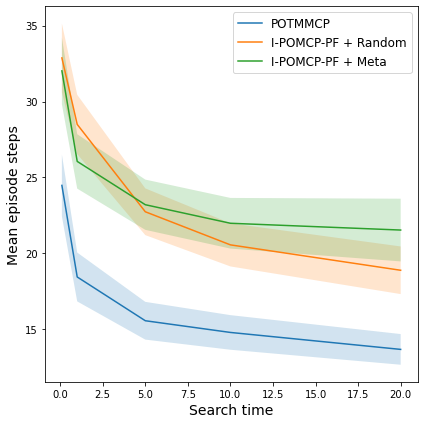

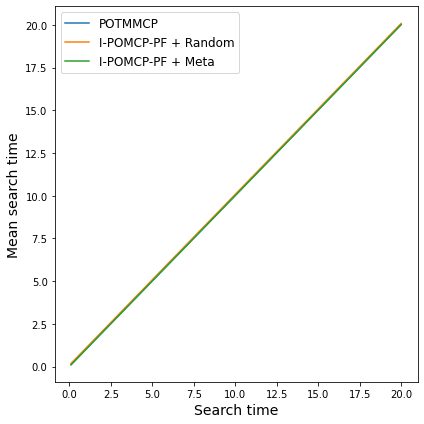

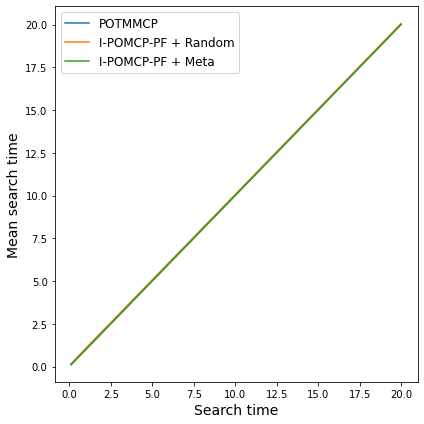

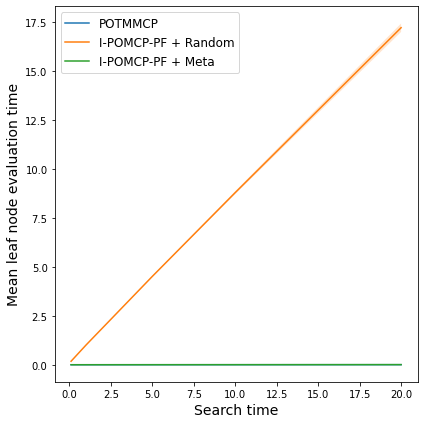

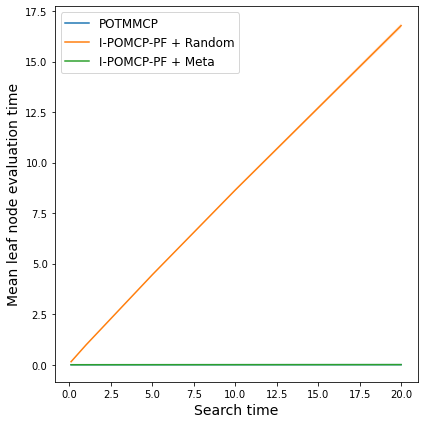

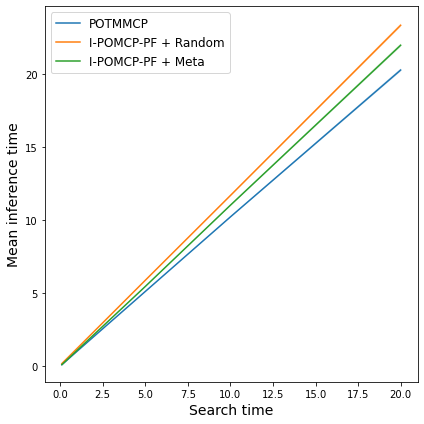

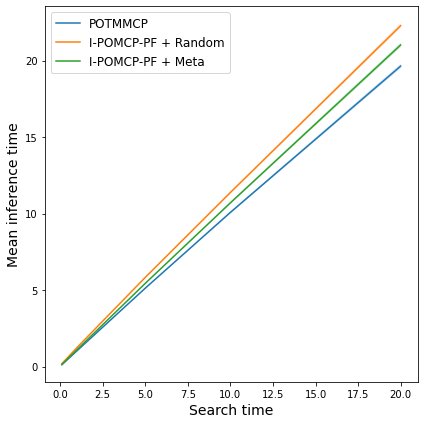

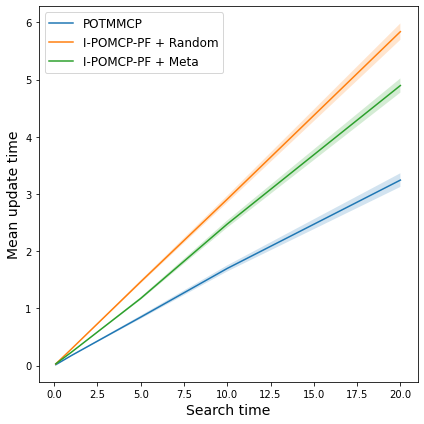

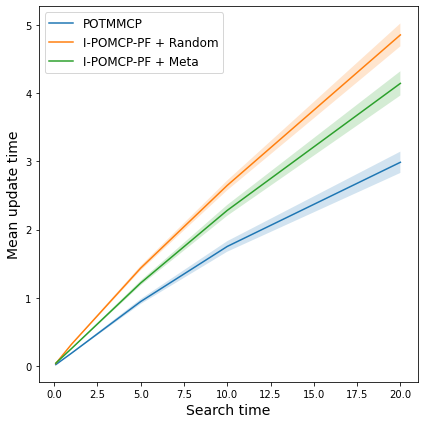

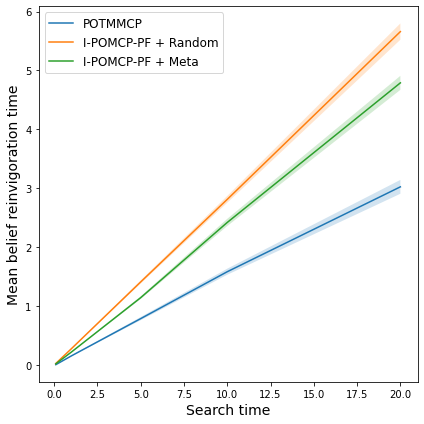

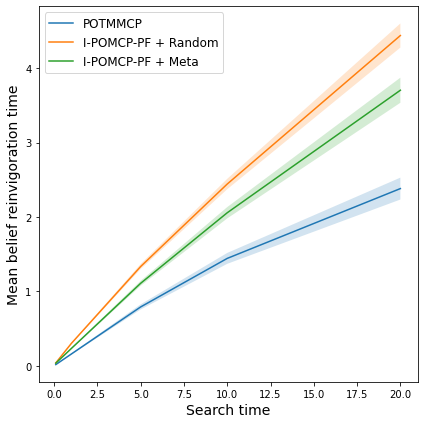

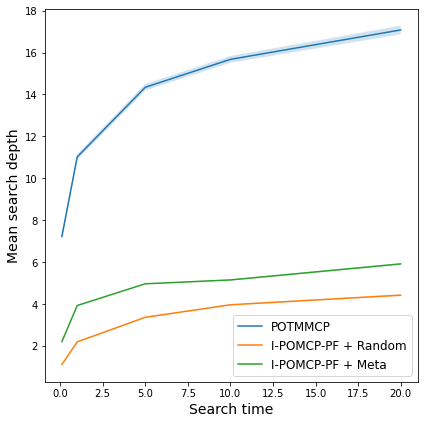

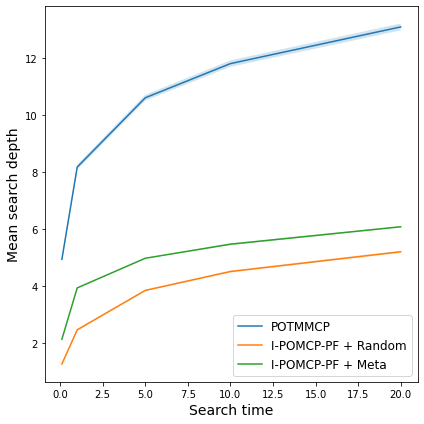

In [41]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "xlabel": "Search time"
    # "ylim": (0, 75),
})
plot_kwargs["legend_kwargs"].update({
    # "loc": 'upper left',
})
agent_dfs = {
    i: search_time_df[search_time_df["agent_id"] == i] for i in (0, 1)
}

for (y_key, y_label) in [
    ("episode_steps", "Mean episode steps"),
    ("search_time", "Mean search time"),
    ("evaluation_time", "Mean leaf node evaluation time"),
    ("inference_time", "Mean inference time"),
    ("update_time", "Mean update time"),
    ("reinvigoration_time", "Mean belief reinvigoration time"),
    ("search_depth", "Mean search depth")
]:
    plot_kwargs["subplot_kwargs"].update({
        "ylabel": y_label,
    })
    for agent_id, agent_df in agent_dfs.items():
        print(f"{y_key=} {agent_id=}")
        fig, _ = plot_utils.paper.plot_multiple_performance(
            agent_df,
            x_key="search_time_limit",
            y_key=f"{y_key}_mean",
            y_err_key=f"{y_key}_CI",
            policy_prefixes=[policy_prefixes_to_plot],
            pi_label_map=baseline_pi_label_map,
            constant_policy_prefixes=[],
            **plot_kwargs,
        )

        fig.tight_layout()
        fig.savefig(osp.join(figure_dir, f"{y_key}_i{agent_id}.png"))
    
del plot_kwargs